# Building an Image Pipeline

Resources:
- https://pgaleone.eu/tensorflow/2018/07/28/understanding-tensorflow-tensors-shape-static-dynamic/
- https://www.tensorflow.org/guide/data
- https://cs230-stanford.github.io/tensorflow-input-data.html#building-an-image-data-pipeline
- https://medium.com/ymedialabs-innovation/how-to-use-dataset-and-iterators-in-tensorflow-with-code-samples-3bb98b6b74ab

In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(0,'..')
from dataset_collection.dataset.image import tiny_imagenet

/home/ricky/Envs/py3-tf1.14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ricky/Envs/py3-tf1.14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ricky/Envs/py3-tf1.14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ricky/Envs/py3-tf1.14/lib/python3.7/site-packages/tensorflow/

In [2]:
def read_image(filename):
    
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image

def rescale_image(image, size=(227,227)):
    return tf.image.resize(image, size)

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

def ensure_rgb(image):
    image_rgb = tf.cond(tf.equal(tf.shape(image)[-1], 3),
                        lambda: image,
                        lambda: tf.image.grayscale_to_rgb(image))

    image_rgb.set_shape((None, None, 3))

    return image_rgb

In [4]:
DATASET_ROOT = '../../data'

dset = tiny_imagenet(DATASET_ROOT)
df = dset.get_description_map()
label_to_index = { k: idx for idx, (k,v) in enumerate(df.items()) }
index_to_label = { v: k for k,v in label_to_index.items() }

In [5]:
uris, labels = dset.get_train_dataset()
for URI, label in zip(uris[:5], labels[:5]):
    print('{} --> {}'.format(label, URI))

n01443537 --> ../../data/tiny-imagenet-200/../../data/tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG
n01443537 --> ../../data/tiny-imagenet-200/../../data/tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_1.JPEG
n01443537 --> ../../data/tiny-imagenet-200/../../data/tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_10.JPEG
n01443537 --> ../../data/tiny-imagenet-200/../../data/tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_100.JPEG
n01443537 --> ../../data/tiny-imagenet-200/../../data/tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_101.JPEG


In [6]:
batch_size=1024
reshape_to=(200,200)
epochs=1
prefetch=1

# STRING LABELS TO INTEGERS
dataset = tf.data.Dataset.from_tensor_slices((uris, labels))
# dataset = dataset.shuffle(len(uris))
dataset = dataset.map(lambda feature, label: [read_image(feature), label], num_parallel_calls=4)
dataset = dataset.map(lambda feature, label: [rescale_image(feature, size=reshape_to), label], num_parallel_calls=4)
dataset = dataset.map(lambda feature, label: [ensure_rgb(feature), label], num_parallel_calls=4)
dataset = dataset.repeat(epochs)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(prefetch)

In [7]:
for idx, item in enumerate(dataset):
    image, label = item
    print('{} --> features: {} labels: {}'.format(idx, image.get_shape(), label.get_shape()))     

0 --> features: (1024, 200, 200, 3) labels: (1024,)
1 --> features: (1024, 200, 200, 3) labels: (1024,)
2 --> features: (1024, 200, 200, 3) labels: (1024,)
3 --> features: (1024, 200, 200, 3) labels: (1024,)
4 --> features: (1024, 200, 200, 3) labels: (1024,)
5 --> features: (1024, 200, 200, 3) labels: (1024,)
6 --> features: (1024, 200, 200, 3) labels: (1024,)
7 --> features: (1024, 200, 200, 3) labels: (1024,)
8 --> features: (1024, 200, 200, 3) labels: (1024,)
9 --> features: (1024, 200, 200, 3) labels: (1024,)
10 --> features: (1024, 200, 200, 3) labels: (1024,)
11 --> features: (1024, 200, 200, 3) labels: (1024,)
12 --> features: (1024, 200, 200, 3) labels: (1024,)
13 --> features: (1024, 200, 200, 3) labels: (1024,)
14 --> features: (1024, 200, 200, 3) labels: (1024,)
15 --> features: (1024, 200, 200, 3) labels: (1024,)
16 --> features: (1024, 200, 200, 3) labels: (1024,)
17 --> features: (1024, 200, 200, 3) labels: (1024,)
18 --> features: (1024, 200, 200, 3) labels: (1024,)
19 

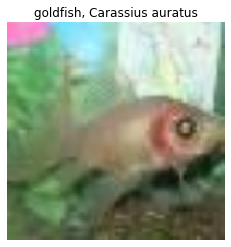

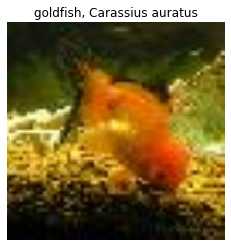

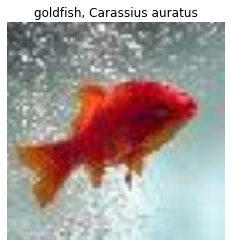

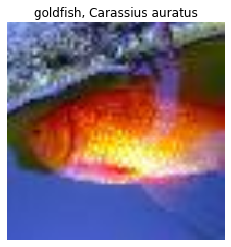

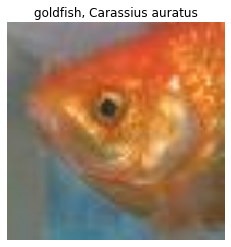

In [8]:
for idx, item in enumerate(dataset.take(1)):
    image, label = item
    for img, ll in zip(image[:5], label[:5]):
        show(img, df[ll.numpy().decode()])